In [3]:
!pip install kornia
!pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
import os
import csv

# Device setup
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cpu':
    raise RuntimeError("This code requires a GPU for torch.float16. Please enable GPU runtime in Colab.")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3u1_4tem
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3u1_4tem
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [4]:


drive.mount('/content/drive')
checkpoint_path = '/content/drive/MyDrive/GNN_project/lambda_model.pth'
log_path = '/content/drive/MyDrive/GNN_project/logs/'
dataset_path = '/content/drive/MyDrive/GNN_project/dataset.pkl'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
os.makedirs(log_path, exist_ok=True)

class FrozenClipImageEmbedder(nn.Module):
    def __init__(self, device=DEVICE):
        super().__init__()
        self.model, _ = clip.load('ViT-L/14', device=device)
        self.device = device
        self.preprocess = lambda img: torch.tensor(np.array(img.resize((224, 224))) / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    def forward(self, img):
        img_tensor = self.preprocess(img)
        return self.model.encode_image(img_tensor)

def summarize_labels(labels, max_items=1):
    labels = eval(labels) if isinstance(labels, str) else labels
    return ", ".join(labels[:max_items])

def load_data(pickle_filename):
    with open(pickle_filename, "rb") as f:
        return pickle.load(f)

def soft_combine_embeddings(c0, c1, lambda_t):
    lambda_t = lambda_t.reshape(-1, 1, 1)  # Shape: [T, 1, 1], broadcasts over [1, 77, 768]
    return lambda_t * c1 + (1 - lambda_t) * c0  # Output: [1, 77, 768]

def find_pairs(dataset):
    pairs = []
    filename_to_sample = {sample[0].split('_')[0]: sample for sample in dataset}
    for sample in dataset:
        if sample[2] == "PA":
            pa_prefix = sample[0].split('_')[0]
            l_sample = next((s for s in dataset if s[2] == "L" and s[0].split('_')[0] == pa_prefix), None)
            if l_sample:
                pairs.append((sample, l_sample))
    print(f"Found {len(pairs)} PA-L pairs.")
    return pairs


def compute_loss(generated_img, real_l_img):
    img_embedder = FrozenClipImageEmbedder().to(DEVICE)
    with torch.no_grad():
        real_emb = img_embedder(real_l_img)
    gen_emb = img_embedder(generated_img)
    return -F.cosine_similarity(gen_emb, real_emb).mean()

def train_lambda(pairs, T=1, epochs=5, lr=1e-3):
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("Nihirc/Prompt2MedImage", torch_dtype=torch.float16).to(DEVICE)

    lambda_t = torch.nn.Parameter(torch.ones(T, device=DEVICE) * 0.5, requires_grad=True)
    optimizer = torch.optim.Adam([lambda_t], lr=lr)

    log_file = os.path.join(log_path, "training_log.csv")
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Loss"])

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for pa_sample, l_sample in pairs[:2]:
            generated_l_img = generate_l_from_pa(pa_sample, lambda_t, pipe)
            real_l_img = Image.fromarray(l_sample[1]).convert("RGB")

            loss = compute_loss(generated_l_img, real_l_img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(pairs[:2])
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        torch.save({"lambda_t": lambda_t.detach().cpu(), "optimizer_state": optimizer.state_dict()}, checkpoint_path)
        with open(log_file, "a", newline="") as f:
            csv.writer(f).writerow([epoch+1, avg_loss])

    plt.plot(range(1, epochs+1), losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return lambda_t

def visualize_views(pa_sample, real_l_sample, generated_l_img):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(pa_sample[1], cmap='gray')
    plt.title(f"Input PA: {pa_sample[0]}")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(real_l_sample[1], cmap='gray')
    plt.title(f"Real L: {real_l_sample[0]}")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(generated_l_img, cmap='gray')
    plt.title(f"Generated L (lambda_t={trained_lambda_t.item():.3f})")
    plt.axis("off")
    plt.show()
    print(f"Lambda_t value: {trained_lambda_t.item():.3f}")



Mounted at /content/drive


In [5]:
def generate_l_from_pa(pa_sample, lambda_t, pipe, num_inference_steps=30, strength=0.7):
    filename, img_array, _, labels = pa_sample

    print(f"img_array type: {type(img_array)}, shape: {img_array.shape}, dtype: {img_array.dtype}")

    if not isinstance(img_array, np.ndarray):
        raise ValueError(f"img_array must be a NumPy array, got {type(img_array)}")
    if len(img_array.shape) not in [2, 3]:
        raise ValueError(f"img_array must be 2D or 3D, got shape {img_array.shape}")

    init_image = Image.fromarray(img_array).convert("RGB")
    print(f"init_image type: {type(init_image)}")

    image_processor = pipe.image_processor
    init_image_processed = image_processor.preprocess(
        init_image, height=512, width=512
    )
    print(f"init_image_processed type: {type(init_image_processed)}, shape: {init_image_processed.shape}")

    label_text = summarize_labels(labels)
    neutral_prompt = f"A chest X-ray with {label_text}"
    l_prompt = f"A chest X-ray with {label_text} taken in L orientation"

    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder
    neutral_inputs = tokenizer([neutral_prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
    l_inputs = tokenizer([l_prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")

    with torch.no_grad():
        neutral_emb = text_encoder(neutral_inputs.input_ids.to(DEVICE))[0]  # Shape: [1, 77, 768]
        l_emb = text_encoder(l_inputs.input_ids.to(DEVICE))[0]              # Shape: [1, 77, 768]
        prompt_embeds = soft_combine_embeddings(neutral_emb, l_emb, lambda_t)  # Shape: [1, 77, 768]
        print(f"prompt_embeds shape: {prompt_embeds.shape}")  # Debug

    return pipe(
        prompt_embeds=prompt_embeds,
        image=init_image_processed,
        strength=strength,
        num_inference_steps=num_inference_steps,
        guidance_scale=7.5
    ).images[0]

Found 978 PA-L pairs.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 890M/890M [00:13<00:00, 67.8MiB/s]


img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5, Loss: -0.8928
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5, Loss: -0.8948
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5, Loss: -0.8831
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5, Loss: -0.8938
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5, Loss: -0.8633


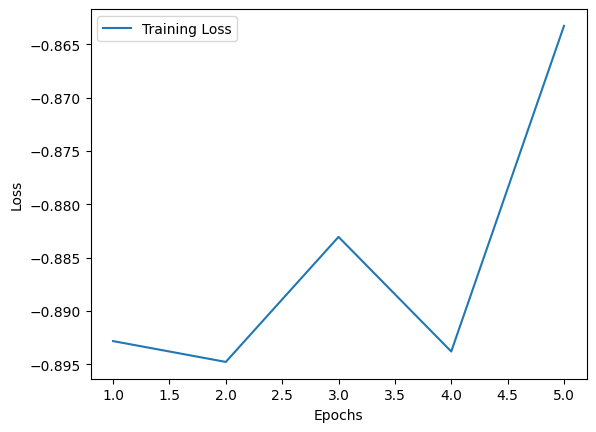

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8
init_image type: <class 'PIL.Image.Image'>
init_image_processed type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 512, 512])
prompt_embeds shape: torch.Size([1, 77, 768])


  0%|          | 0/21 [00:00<?, ?it/s]

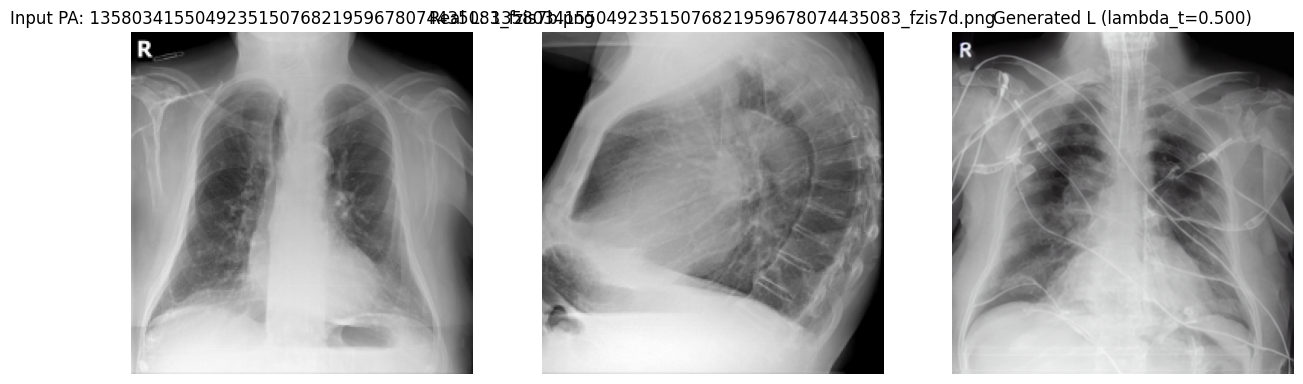

Lambda_t value: 0.500
Generated L view saved to: /content/drive/MyDrive/generated_l_135803415504923515076821959678074435083_fzis7b.png


In [6]:
if __name__ == "__main__":
    dataset = load_data(dataset_path)
    pairs = find_pairs(dataset)
    if not pairs:
        raise ValueError("No PA-L pairs found in dataset!")

    # Train lambda_t
    trained_lambda_t = train_lambda(pairs, T=1, epochs=5)

    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("Nihirc/Prompt2MedImage", torch_dtype=torch.float16).to(DEVICE)
    pa_sample, l_sample = pairs[0]
    generated_l_img = generate_l_from_pa(pa_sample, trained_lambda_t, pipe)
    visualize_views(pa_sample, l_sample, generated_l_img)

    output_path = f"/content/drive/MyDrive/generated_l_{pa_sample[0]}"
    generated_l_img.save(output_path)
    print(f"Generated L view saved to: {output_path}")